In [1]:
from datasets import load_dataset, Features, Value, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from time import localtime, strftime

In [2]:
dataset = load_dataset("csv", 
                       data_files={split: f"../D1/{split}.csv" for split in ["train", "val", "test"]},
                       features=Features({
                            "text": Value(dtype="string"),
                            "labels": ClassLabel(num_classes=8, names=["neutral", "joy", "sadness", "fear", "anger", "surprise", "disgust", "non-neutral"])
                       }))

In [3]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def preprocess_data(examples):
    encoding = tokenizer(examples["text"], max_length=128, truncation=True)

    return encoding

tokenized_dataset = dataset.map(preprocess_data, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [4]:
def get_model():
    return AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=8)

In [5]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    metrics = {
        "WA": accuracy_score(labels, predictions).tolist(),
        "UWA": balanced_accuracy_score(labels, predictions).tolist(),
        "miF1": f1_score(labels, predictions, average="micro"),
        "maF1": f1_score(labels, predictions, average="macro"),
        "wtF1": f1_score(labels, predictions, average="weighted"),
    }

    return metrics

In [6]:
loss_fn = nn.CrossEntropyLoss(torch.Tensor(1/np.bincount(dataset["train"]["labels"])).to("cuda"))

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)

        loss = loss_fn(outputs["logits"], labels)
        return (loss, outputs) if return_outputs else loss

In [7]:
raise Exception

Exception: 

In [8]:
dir_name = strftime("%b-%d-%y-%H:%M:%S", localtime())

training_args = TrainingArguments(
    output_dir=f"results/{dir_name}",
    logging_dir=f"results/{dir_name}/runs",
    evaluation_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=2e-6,
    max_grad_norm=1.0,
    num_train_epochs=40,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_strategy="epoch",
    report_to="none",
    save_strategy="epoch",
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
)

trainer = WeightedTrainer(
    model_init=get_model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3320 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 2.0935, 'learning_rate': 1e-06, 'epoch': 1.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 2.0751402378082275, 'eval_WA': 0.12818336162988114, 'eval_UWA': 0.125, 'eval_miF1': 0.12818336162988114, 'eval_maF1': 0.028404815650865313, 'eval_wtF1': 0.029128198052839813, 'eval_runtime': 0.5205, 'eval_samples_per_second': 2263.224, 'eval_steps_per_second': 36.504, 'epoch': 1.0}
{'loss': 2.081, 'learning_rate': 2e-06, 'epoch': 2.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 2.0496485233306885, 'eval_WA': 0.18505942275042445, 'eval_UWA': 0.1947068434556475, 'eval_miF1': 0.18505942275042447, 'eval_maF1': 0.08201058161883876, 'eval_wtF1': 0.12733553076906146, 'eval_runtime': 0.5221, 'eval_samples_per_second': 2256.329, 'eval_steps_per_second': 36.392, 'epoch': 2.0}
{'loss': 1.9854, 'learning_rate': 1.8888888888888888e-06, 'epoch': 3.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.8970136642456055, 'eval_WA': 0.23514431239388794, 'eval_UWA': 0.28412278236546606, 'eval_miF1': 0.23514431239388794, 'eval_maF1': 0.1850127120256101, 'eval_wtF1': 0.21415949591250164, 'eval_runtime': 0.5161, 'eval_samples_per_second': 2282.447, 'eval_steps_per_second': 36.814, 'epoch': 3.0}
{'loss': 1.8039, 'learning_rate': 1.7777777777777775e-06, 'epoch': 4.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.720008373260498, 'eval_WA': 0.42784380305602715, 'eval_UWA': 0.37944969064906, 'eval_miF1': 0.42784380305602715, 'eval_maF1': 0.297742495871679, 'eval_wtF1': 0.41322760455336627, 'eval_runtime': 0.5192, 'eval_samples_per_second': 2269.092, 'eval_steps_per_second': 36.598, 'epoch': 4.0}
{'loss': 1.6379, 'learning_rate': 1.6666666666666667e-06, 'epoch': 5.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.6382476091384888, 'eval_WA': 0.4855687606112054, 'eval_UWA': 0.41018269346983727, 'eval_miF1': 0.4855687606112054, 'eval_maF1': 0.33691331221565884, 'eval_wtF1': 0.45779012452087764, 'eval_runtime': 0.5196, 'eval_samples_per_second': 2267.17, 'eval_steps_per_second': 36.567, 'epoch': 5.0}
{'loss': 1.5432, 'learning_rate': 1.5555555555555556e-06, 'epoch': 6.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.582822322845459, 'eval_WA': 0.4923599320882852, 'eval_UWA': 0.4369063089997175, 'eval_miF1': 0.4923599320882852, 'eval_maF1': 0.3560840246692215, 'eval_wtF1': 0.467746039670733, 'eval_runtime': 0.5104, 'eval_samples_per_second': 2308.129, 'eval_steps_per_second': 37.228, 'epoch': 6.0}
{'loss': 1.4707, 'learning_rate': 1.4444444444444443e-06, 'epoch': 7.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5513134002685547, 'eval_WA': 0.47538200339558573, 'eval_UWA': 0.4490272264052798, 'eval_miF1': 0.47538200339558573, 'eval_maF1': 0.35324156298829146, 'eval_wtF1': 0.4532998981201064, 'eval_runtime': 0.514, 'eval_samples_per_second': 2291.616, 'eval_steps_per_second': 36.962, 'epoch': 7.0}
{'loss': 1.4219, 'learning_rate': 1.3333333333333332e-06, 'epoch': 8.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5512614250183105, 'eval_WA': 0.4966044142614601, 'eval_UWA': 0.44641730333708174, 'eval_miF1': 0.4966044142614601, 'eval_maF1': 0.3617734111686863, 'eval_wtF1': 0.4712325033479196, 'eval_runtime': 0.5224, 'eval_samples_per_second': 2255.069, 'eval_steps_per_second': 36.372, 'epoch': 8.0}
{'loss': 1.3725, 'learning_rate': 1.2222222222222223e-06, 'epoch': 9.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5279462337493896, 'eval_WA': 0.5033955857385399, 'eval_UWA': 0.4544066372869584, 'eval_miF1': 0.5033955857385399, 'eval_maF1': 0.3721697227245806, 'eval_wtF1': 0.4825364248805673, 'eval_runtime': 0.5209, 'eval_samples_per_second': 2261.508, 'eval_steps_per_second': 36.476, 'epoch': 9.0}
{'loss': 1.3386, 'learning_rate': 1.111111111111111e-06, 'epoch': 10.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5283066034317017, 'eval_WA': 0.49575551782682514, 'eval_UWA': 0.44683485330521877, 'eval_miF1': 0.49575551782682514, 'eval_maF1': 0.36289649537422797, 'eval_wtF1': 0.47330625221919714, 'eval_runtime': 0.5242, 'eval_samples_per_second': 2247.201, 'eval_steps_per_second': 36.245, 'epoch': 10.0}
{'loss': 1.3136, 'learning_rate': 1e-06, 'epoch': 11.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.506002426147461, 'eval_WA': 0.4932088285229202, 'eval_UWA': 0.457559970658757, 'eval_miF1': 0.4932088285229202, 'eval_maF1': 0.3686434269663041, 'eval_wtF1': 0.47589940057401514, 'eval_runtime': 0.5238, 'eval_samples_per_second': 2248.929, 'eval_steps_per_second': 36.273, 'epoch': 11.0}
{'loss': 1.2875, 'learning_rate': 8.888888888888888e-07, 'epoch': 12.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5119301080703735, 'eval_WA': 0.499151103565365, 'eval_UWA': 0.46387365593960084, 'eval_miF1': 0.499151103565365, 'eval_maF1': 0.3739255939219909, 'eval_wtF1': 0.47785928340609246, 'eval_runtime': 0.527, 'eval_samples_per_second': 2235.181, 'eval_steps_per_second': 36.051, 'epoch': 12.0}
{'loss': 1.2624, 'learning_rate': 7.777777777777778e-07, 'epoch': 13.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5109686851501465, 'eval_WA': 0.49830220713073003, 'eval_UWA': 0.4645946651513736, 'eval_miF1': 0.49830220713073003, 'eval_maF1': 0.3764041707656509, 'eval_wtF1': 0.4803191430265243, 'eval_runtime': 0.515, 'eval_samples_per_second': 2287.515, 'eval_steps_per_second': 36.895, 'epoch': 13.0}
{'loss': 1.2408, 'learning_rate': 6.666666666666666e-07, 'epoch': 14.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5099514722824097, 'eval_WA': 0.499151103565365, 'eval_UWA': 0.4649589688865191, 'eval_miF1': 0.499151103565365, 'eval_maF1': 0.37402826631788844, 'eval_wtF1': 0.47941283859222183, 'eval_runtime': 0.5115, 'eval_samples_per_second': 2303.012, 'eval_steps_per_second': 37.145, 'epoch': 14.0}
{'loss': 1.2176, 'learning_rate': 5.555555555555555e-07, 'epoch': 15.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5104717016220093, 'eval_WA': 0.49745331069609505, 'eval_UWA': 0.46030780509348945, 'eval_miF1': 0.49745331069609505, 'eval_maF1': 0.3717221731911885, 'eval_wtF1': 0.48149172992163897, 'eval_runtime': 0.512, 'eval_samples_per_second': 2300.617, 'eval_steps_per_second': 37.107, 'epoch': 15.0}
{'loss': 1.2141, 'learning_rate': 4.444444444444444e-07, 'epoch': 16.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5063796043395996, 'eval_WA': 0.49745331069609505, 'eval_UWA': 0.4648895637485956, 'eval_miF1': 0.49745331069609505, 'eval_maF1': 0.37451198897090415, 'eval_wtF1': 0.4835022833269499, 'eval_runtime': 0.5106, 'eval_samples_per_second': 2307.151, 'eval_steps_per_second': 37.212, 'epoch': 16.0}
{'loss': 1.2075, 'learning_rate': 3.333333333333333e-07, 'epoch': 17.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.50586998462677, 'eval_WA': 0.50169779286927, 'eval_UWA': 0.4641939755054736, 'eval_miF1': 0.50169779286927, 'eval_maF1': 0.37718174313758857, 'eval_wtF1': 0.486194272884471, 'eval_runtime': 0.5105, 'eval_samples_per_second': 2307.541, 'eval_steps_per_second': 37.218, 'epoch': 17.0}
{'loss': 1.1915, 'learning_rate': 2.222222222222222e-07, 'epoch': 18.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.4996262788772583, 'eval_WA': 0.5042444821731749, 'eval_UWA': 0.47283553764451824, 'eval_miF1': 0.5042444821731749, 'eval_maF1': 0.38274925670215665, 'eval_wtF1': 0.48670589894256955, 'eval_runtime': 0.5133, 'eval_samples_per_second': 2294.998, 'eval_steps_per_second': 37.016, 'epoch': 18.0}
{'loss': 1.1701, 'learning_rate': 1.111111111111111e-07, 'epoch': 19.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5098594427108765, 'eval_WA': 0.5076400679117148, 'eval_UWA': 0.4737015036364425, 'eval_miF1': 0.5076400679117148, 'eval_maF1': 0.3853802822676351, 'eval_wtF1': 0.4902615004610157, 'eval_runtime': 0.5124, 'eval_samples_per_second': 2298.808, 'eval_steps_per_second': 37.078, 'epoch': 19.0}
{'loss': 1.1621, 'learning_rate': 0.0, 'epoch': 20.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.5062592029571533, 'eval_WA': 0.5059422750424448, 'eval_UWA': 0.4731923386669924, 'eval_miF1': 0.5059422750424448, 'eval_maF1': 0.38419963516688593, 'eval_wtF1': 0.48893527595462366, 'eval_runtime': 0.5318, 'eval_samples_per_second': 2215.036, 'eval_steps_per_second': 35.726, 'epoch': 20.0}
{'train_runtime': 349.2176, 'train_samples_per_second': 604.838, 'train_steps_per_second': 9.507, 'train_loss': 1.450789812386754, 'epoch': 20.0}


TrainOutput(global_step=3320, training_loss=1.450789812386754, metrics={'train_runtime': 349.2176, 'train_samples_per_second': 604.838, 'train_steps_per_second': 9.507, 'train_loss': 1.450789812386754, 'epoch': 20.0})

In [9]:
raise Exception

Exception: 

In [10]:
trainer.evaluate(tokenized_dataset["test"])

  0%|          | 0/44 [00:00<?, ?it/s]

{'eval_loss': 1.3856546878814697,
 'eval_WA': 0.516642547033285,
 'eval_UWA': 0.5217326527942552,
 'eval_miF1': 0.516642547033285,
 'eval_maF1': 0.38615641129546785,
 'eval_wtF1': 0.511293767854692,
 'eval_runtime': 1.2518,
 'eval_samples_per_second': 2208.101,
 'eval_steps_per_second': 35.151,
 'epoch': 20.0}

In [11]:
predictions = trainer.predict(tokenized_dataset["test"])

  0%|          | 0/44 [00:00<?, ?it/s]

In [12]:
preds = pd.DataFrame(dataset["test"])
preds["pred"] = np.argmax(predictions[0], axis=1)

In [13]:
preds

text  labels  pred
0     Why do all you're coffee mugs have numbers on ...       5     5
1     Oh. That's so Monica can keep track. That way ...       7     0
2                                          Y'know what?       0     0
3                                            It didn't.       0     0
4     Okay, so what you used to have with Rachel, is...       1     0
...                                                 ...     ...   ...
2759  Hey, why don't you guys go get portraits done ...       0     0
2760  That's a good idea! I bet they have one of tho...       1     1
2761  Yeah that's great! Next to that, Chandler won'...       0     1
2762                          Chandler what do you say?       0     0
2763  All right, but I should warn you, I'm not goin...       0     3

[2764 rows x 3 columns]

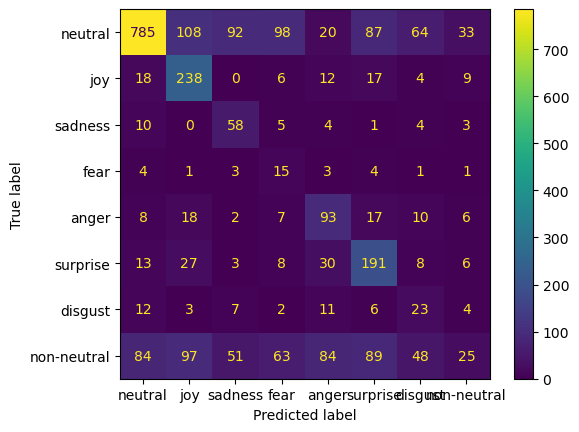

In [14]:
ConfusionMatrixDisplay.from_predictions(preds["labels"], preds["pred"], display_labels=dataset["train"].features["labels"].names)